# II. Computing vegetation index

---
From the satellite time-series, we calculate vegetation indices for each date and store this new information in a Data cube.
In a second step, we filter the cube in such a way as to only keep the images that seem useful.

---
## 1. Import librairies

In [1]:
import os

# xarray
import xarray as xr

---
## 2. Load of satellite time-series

### 2.1. NetCDF file to Xarray Dataset

We open the file created in the [previous notebook](01_array2files.ipynb).

In [2]:
startdate = "2018-01"
enddate = "2022-12"
output_dir = "output"

array = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}.nc')
    )

array

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 284, x: 398, time: 692)
Coordinates:
  * y            (y) float64 2kB 2.914e+06 2.914e+06 ... 2.911e+06 2.911e+06
  * x            (x) float64 3kB 3.952e+06 3.952e+06 ... 3.956e+06 3.956e+06
  * time         (time) datetime64[ns] 6kB 2018-01-01T10:54:41.026000 ... 202...
Data variables:
    spatial_ref  int32 4B ...
    B02          (time, y, x) float32 313MB ...
    B03          (time, y, x) float32 313MB ...
    B04          (time, y, x) float32 313MB ...
    B05          (time, y, x) float32 313MB ...
    B06          (time, y, x) float32 313MB ...
    B07          (time, y, x) float32 313MB ...
    B08          (time, y, x) float32 313MB ...
    B8A          (time, y, x) float32 313MB ...
    B11          (time, y, x) float32 313MB ...
    B12          (time, y, x) float32 313MB ...
    SCL          (time, y, x) float32 313MB ...

### 2.2. Filtering images according to SCL values

The Level-2A processing includes a Scene Classification and an Atmospheric Correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. The Scene Classification (SCL) was developed to distinguish between cloudy pixels, clear pixels and water pixels of Sentinel-2 data and is a result of the Scene classification algorithm run by ESA. 

![fig_nrt](img/SCL.png)

For instance, we keep pixels values only related to the SCL classes: vegetation, non-vegetation and unclassified.
Then, we remove the SCL band for each variable in the data set.

In [3]:
cube = array.where(array.SCL.isin([4,5,7]))
cube = cube.drop_vars('SCL')
print(f"number of dates {len(cube.time)}")

number of dates 692


---

## 3. Data reduction into univariate series

### 3.1. Computing vegetation indices (VI)

We calculate three vegetation indices:
- **NDVI** (*Normalized Difference Vegetation Index*): index used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health (*source: USGS*).
- **NDMI** (*Normalized Difference Moisture Index*): index used to determine vegetation water content. It is calculated as a ratio between the NIR and SWIR values in traditional fashion (*source: USGS*).
- **CRSWIR** (*Continuum Removal SWIR*): index sensitive to the vegetation water content, and calculated from the near and mid-infrared bands. this involves highlighting the absorption phenomena associated with vegetation water, measurable at the level of band 11 of Sentinel-2, centered in the short-wave infrared (SWiR) around 1600 nm. This index is based on the Continuum Removal (CR) technique which consists of maximizing the spectral contrast associated with absorption photos, by normalizing the reflectance value in relation to the value of a 'convex envelope' calculated from of neighboring spectral bands (*source: Dutrieux R., Feret J.B., Ose K. 2021. Mise au point d'une methode reproductible pour le suivi generalise des degats de scolytes par teledetection satellitaire, ONF-RDVT 69-70,pp.37-44*).

Then, the spectral bands are dropped.

In [4]:
array['ndvi'] = (array.B8A - array.B04) / (array.B8A + array.B04)
array['ndmi'] = (array.B8A - array.B11) / (array.B8A + array.B11)
array['crswir'] = array.B11/(array.B8A+((array.B12-array.B8A)/(2185.7-864))*(1610.4-864))

# add 'grid_mapping' attribute to keep CRS coordinates (cf. export into netCDF)
array.ndvi.attrs = {'grid_mapping': 'spatial_ref'}
array.ndmi.attrs = {'grid_mapping': 'spatial_ref'}
array.crswir.attrs = {'grid_mapping': 'spatial_ref'}

array = array.drop_vars(['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'])

### 3.2. Cloud masks and filtering

#### 3.2.1. Applying cloud masks

We apply a cloud mask made from SCL (cloud shadows, clouds and cirrus) in order not to consider cloudy pixels in the next analyses.

In [60]:
# mask creation
cloud_mask = array.SCL.isin([3, 8, 9, 10])
array_mask = array.where(~cloud_mask)

print(f"number of dates {len(array_mask.time)}")

number of dates 692


#### 3.2.2. Keeping images without clouds
We can also decide to remove all images that are partially or totally covered by clouds and shadows.

In [79]:
array_subset = array_mask.where(cloud_mask.sum(dim=['x', 'y']) == 0, drop=True)

print(f"number of dates {len(array_subset.time)}")

number of dates 126


#### 3.2.3. Keeping images according to a clouds threshold

The previous request is a little too strong. We finally prefer to filter the images according to a percentage of cloudy pixels.

To calculate it, we need to know the dimension of our data cube in x and y.

In [80]:
size = zip(cloud_mask.dims, cloud_mask.shape)
size = list(size)
size

[('time', 692), ('y', 284), ('x', 398)]

We deduce the total number of pixel for each layer of the datacube.

In [81]:
y = [i[1] for i in size if 'y' in i][0]
x = [i[1] for i in size if 'x' in i][0]

pxl_tot = x*y
pxl_tot

113032

Now, it is up to the user to define the most suitable clouds threshold in the `cld_max` variable (here 0.5, i.e. 50%).

In [82]:
cld_max = 0.5
array_cldpct = array_mask.where(cloud_mask.sum(dim=['x', 'y'])/pxl_tot <= cld_max, drop=True)

print(f"number of dates {len(array_cldpct.time)}")

number of dates 271


---
## 4. Plotting the VI time series

Here, we plot the CRSWIR time-series with all the dates (object `array_mask`) and without totally clouded images (object `array_subset`).

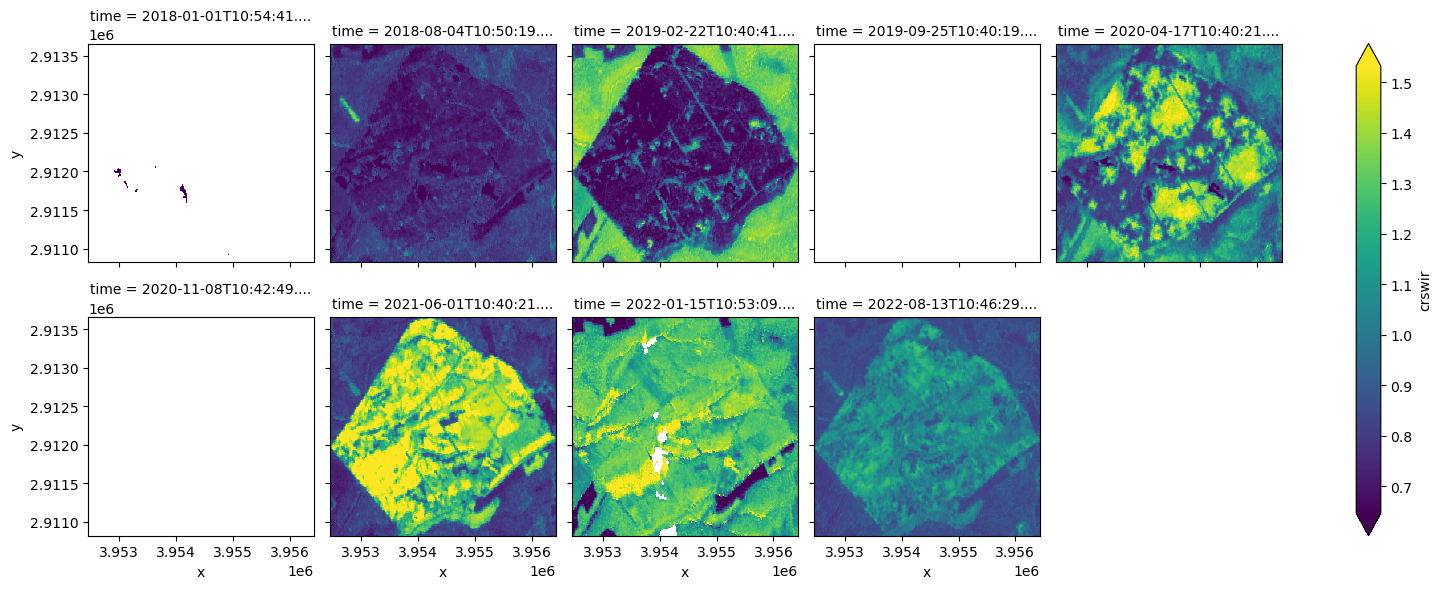

In [83]:
array_mask.crswir[::80].plot.imshow(col_wrap=5, col="time", robust=True, size=3)

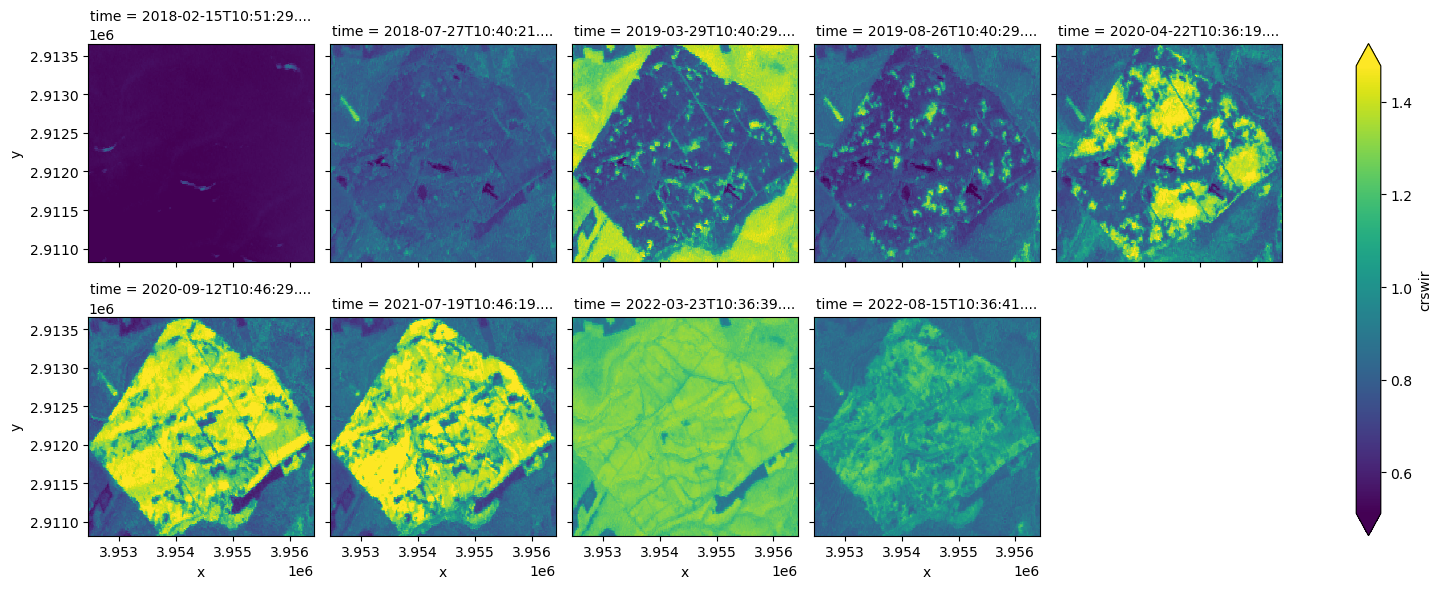

In [84]:
array_subset.crswir[::15].plot.imshow(col_wrap=5, col="time", robust=True, size=3)

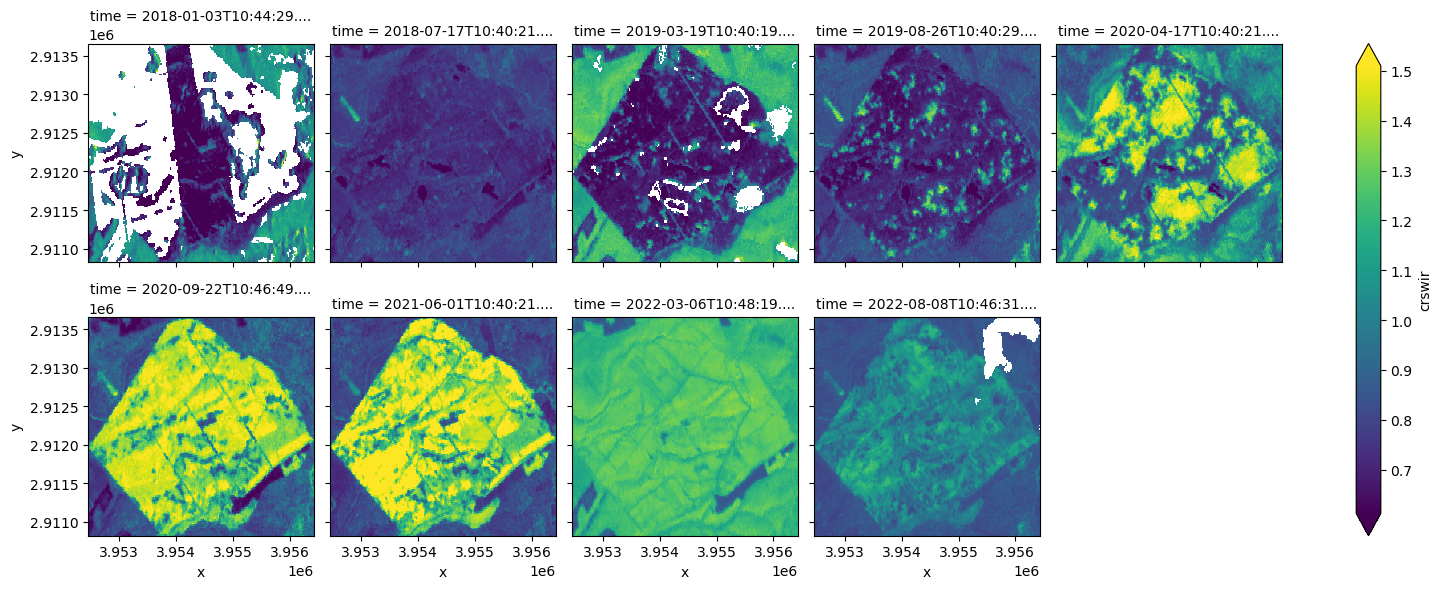

In [85]:
array_cldpct.crswir[::32].plot.imshow(col_wrap=5, col="time", robust=True, size=3)

---

## 5. Saving time series as netCDF files

for practical reasons, we propose here to save the VI time-series in NETCDF files.

### 5.1. The whole time series with cloud masked

In [9]:
array_mask.to_netcdf(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-mask.nc')
    )

### 5.2. The partial time series without cloudy images

In [10]:
array_subset.to_netcdf(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-nocloud.nc')
    )

### 5.3. The partial time series without some cloudy images (threshold)

In [86]:
array_cldpct.to_netcdf(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-cloud_inf_{cld_max}.nc')
    )